In [1]:
#%pip install tensorflow

In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tickerData import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = getTickerData(ticker="btc-usd", period="max", interval="1d")
df.drop(columns={'Adj Close'}, inplace=True)
df.rename(columns={'Date':'date', 'Open':'open', 'High':'high','Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)
df

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...,...
3097,2023-03-11,20187.876953,20792.525391,20068.660156,20632.410156,30180288176
3098,2023-03-12,20628.029297,22185.031250,20448.806641,22163.949219,29279035521
3099,2023-03-13,22156.406250,24550.837891,21918.199219,24197.533203,49466362688
3100,2023-03-14,24201.765625,26514.716797,24081.183594,24746.074219,54622230164


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3102 non-null   datetime64[ns]
 1   open    3102 non-null   float64       
 2   high    3102 non-null   float64       
 3   low     3102 non-null   float64       
 4   close   3102 non-null   float64       
 5   volume  3102 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 145.5 KB


In [5]:
close_prices = df['close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
2422/2422 [==============================] - 44s 17ms/step - loss: 0.0023
Epoch 2/3
2422/2422 [==============================] - 43s 18ms/step - loss: 7.7516e-04
Epoch 3/3
2422/2422 [==============================] - 43s 18ms/step - loss: 6.1226e-04


In [9]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

20/20 [==============================] - 1s 17ms/step


9892.879504788307

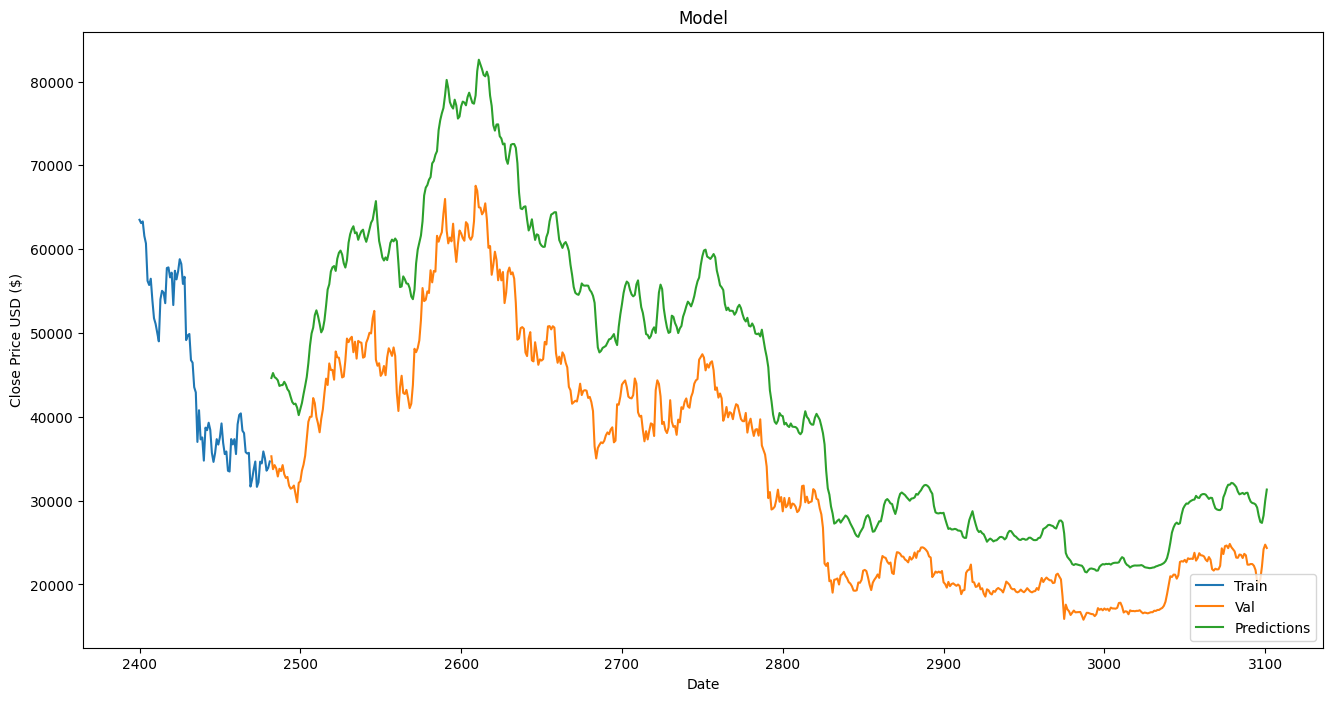

In [10]:
data = df.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train[2400:])
plt.plot(validation[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()